# Mask R-CNN Model Evaluation

Evaluations of our pedestrian instance segmentation model.

## Import Libraries

In [17]:
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(f'Python version: {sys.version.split()[0]}')
print(f'Numpy version: {np.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')

Python version: 3.7.2
Numpy version: 1.16.2
Matplotlib version: 3.0.3


## Plot Loss Over Time

In [1]:
LOG_FILE_PATH = "models/mask_rcnn_resnet_50_supervisely/log.txt"

In [5]:
with open(LOG_FILE_PATH) as f:
    lines = [l for l in f.readlines() if 'iter:' in l]

In [26]:
iters = []
losses = []
for line in lines:
    components = line.split(' ')
    iters.append(float(components[8]))
    losses.append(float(components[11]))

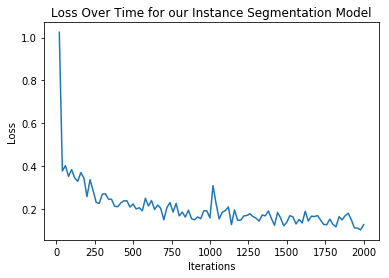

In [35]:
fig, ax = plt.subplots()
ax.plot(iters, losses)
ax.set(xlabel='Iterations', ylabel='Loss',
       title='Loss Over Time for our Instance Segmentation Model')
plt.show()